# Clusterización de textos

In [1]:
# librería necesaria para el dataset
#!pip install wikipedia
#!pip install wordcloud
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import wikipedia
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import re
from wordcloud import WordCloud
from sklearn.metrics import silhouette_score

In [3]:
# se extraen 9 artículos referentes a los siguientes temas:
articles = ['Data Science','Artificial intelligence',          
            'European Central Bank','Bank','Financial technology','International Monetary Fund',          
            'Basketball','Swimming','Tenni']
wiki_lst = []
title = []

for article in articles:
    print("Cargando contenido: ",article)
    wiki_lst.append(wikipedia.page(article, auto_suggest=True).content)
    title.append(article)

Cargando contenido:  Data Science
Cargando contenido:  Artificial intelligence
Cargando contenido:  European Central Bank
Cargando contenido:  Bank
Cargando contenido:  Financial technology
Cargando contenido:  International Monetary Fund
Cargando contenido:  Basketball
Cargando contenido:  Swimming
Cargando contenido:  Tenni


<br>
Se ejecuta la transformación TFIDF de los documentos extraídos.


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words={'english'})
X = vectorizer.fit_transform(wiki_lst)

<br>
Se ejecuta el método de KMeans para clustering y se estima el número óptimo de clusters a través del método del codo.

Para este problema, el número de clusters debe ser menor a 9 (número de documentos extraídos).

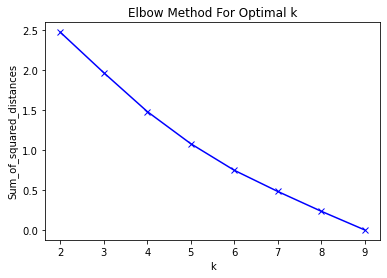

In [5]:
Sum_of_squared_distances = []
K = range(2,10)
for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

<br>
Se escoge arbritrariamente un $k=6$ y se muestra a que cluster pertenece cada documento.

In [6]:
true_k = 6
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
model.fit(X)
labels=model.labels_
wiki_cl=pd.DataFrame(list(zip(title,labels)),columns=['title','cluster'])
print(wiki_cl.sort_values(by=['cluster']))

                         title  cluster
6                   Basketball        0
8                        Tenni        0
2        European Central Bank        1
3                         Bank        1
5  International Monetary Fund        1
0                 Data Science        2
7                     Swimming        3
1      Artificial intelligence        4
4         Financial technology        5


Para mostrar los resultados en términos de términos más importantes en un cluster, se muestra un WordCloud por cada cluster.

Cluster: 0
Titles
 Basketball
      Tenni


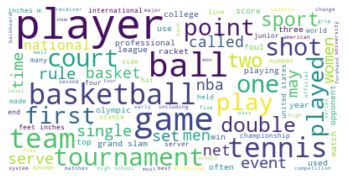

Cluster: 1
Titles
       European Central Bank
                        Bank
 International Monetary Fund


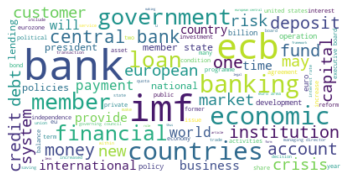

Cluster: 2
Titles
 Data Science


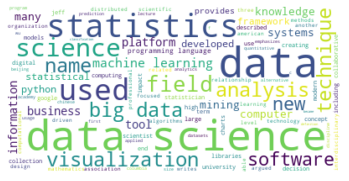

Cluster: 3
Titles
 Swimming


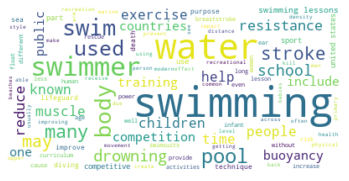

Cluster: 4
Titles
 Artificial intelligence


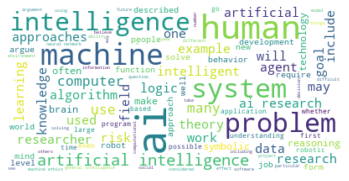

Cluster: 5
Titles
 Financial technology


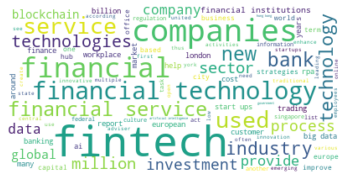

In [7]:
result={'cluster':labels,'wiki':wiki_lst}
result=pd.DataFrame(result)

for k in range(0,true_k):
    s=result[result.cluster==k]
    text=s['wiki'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    
    print('Cluster: {}'.format(k))
    print('Titles')
    
    titles=wiki_cl[wiki_cl.cluster==k]['title']
    
    print(titles.to_string(index=False))
    
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

#### ¿Los clusters hallados tienen sentido?

Los resultados obtenido si tienen sentido, en el cluster 0 hay palabras como torneo, jugadores, campeonatos entre otras que comunmentes se mencionan en el contenido de Basketball y Tennis, el mismo caso sucede en el cluster 3 con European Central Bank, Bank y International Monetary Fund ya que comparten palabras y temas relacionados a los bancos. Por el otro lado, talvez se podrian agrupar Artificial Intelligence, Data Science en un solo cluster.

Ejecutando el método del `silhouette score` para encontrar el número de clusters más óptimo. ¿Los resultados varían?

In [8]:
def calcular_silhouette(x,range_analisis):
    res = []
    
    for c in range_analisis:
        km = KMeans(n_clusters=c,max_iter=200,random_state=10,init='k-means++')
        preds = km.fit_predict(x)
        
        silhouette_avg = silhouette_score(x, preds)
        res.append(silhouette_avg)  
    
    plt.plot(range_analisis, res,'bx-')
    plt.xlabel('Número de clusters')
    plt.ylabel('Silouhette score')
    plt.title('K-Means')
    plt.show()

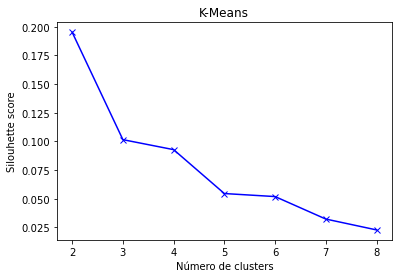

In [9]:
calcular_silhouette(X,range(2,9))

#### Usando la metrica de silhoutte score nos dice que el mejor K es 2. Sin embargo, en la practica no es la mejor opcion, debido a que la clusterización seria muy sencilla y no se realizaria un descubrimiento bueno de los datos. Por esta razon se decide seleccionar un K=3.

In [10]:
true_k = 3
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
model.fit(X)
labels=model.labels_
wiki_cl=pd.DataFrame(list(zip(title,labels)),columns=['title','cluster'])
print(wiki_cl.sort_values(by=['cluster']))

                         title  cluster
7                     Swimming        0
1      Artificial intelligence        1
2        European Central Bank        1
3                         Bank        1
4         Financial technology        1
5  International Monetary Fund        1
6                   Basketball        1
8                        Tenni        1
0                 Data Science        2


Para mostrar los resultados en términos de términos más importantes en un cluster, se muestra un WordCloud por cada cluster.

Cluster: 0
Titles
 Swimming


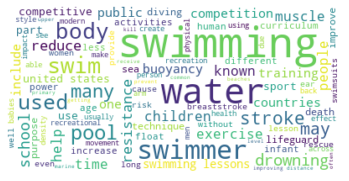

Cluster: 1
Titles
     Artificial intelligence
       European Central Bank
                        Bank
        Financial technology
 International Monetary Fund
                  Basketball
                       Tenni


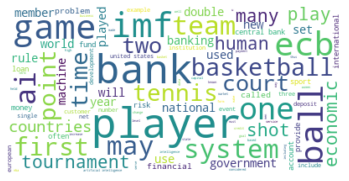

Cluster: 2
Titles
 Data Science


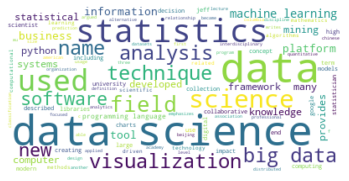

In [11]:
result={'cluster':labels,'wiki':wiki_lst}
result=pd.DataFrame(result)

for k in range(0,true_k):
    s=result[result.cluster==k]
    text=s['wiki'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    
    print('Cluster: {}'.format(k))
    print('Titles')
    
    titles=wiki_cl[wiki_cl.cluster==k]['title']
    
    print(titles.to_string(index=False))
    
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

#### ¿Los resultados varían?

Los resultados varian significativamente. En esta ocasion agrupa en un solo cluster a Artificial intelligence, European Central Bank, Bank, Financial technology, International Monetary Fund, Basketball, Tenni, pienso que talvez se deba a que en estas areas utilizan la inteligencia artificial como un asset de apoyo, incluso terminos como "training, team, time, money".

## Ejercicio 2

Analizar el código a continuación y realizar cada una de las tareas propuestas en el orden planteado.

In [12]:
from bs4 import BeautifulSoup

Lectura del dataset. Para este ejercicio se utilizará el dataset de la base de datos de películas `IMBD` con información sobre sinopsis de películas, géneros, y títulos.

In [13]:
titles = open('data/title_list.txt',encoding='utf8').read().split('\n')
titles =  titles[:100]

genres = open('data/genres_list.txt',encoding='utf8').read().split('\n')
genres = genres[:100]

synopses_wiki = open('data/synopses_list_wiki.txt', encoding='utf8').read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]

synopses_imdb = open('data/synopses_list_imdb.txt').read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]

Se realiza un filtrado de caracteres no deseados en el texto.

In [14]:
synopses_clean_wiki = []
for text in synopses_wiki:
    text = BeautifulSoup(text, 'html.parser').getText()
    synopses_clean_wiki.append(text)
synopses_wiki = synopses_clean_wiki

synopses_clean_imdb = []
for text in synopses_imdb:
    text = BeautifulSoup(text, 'html.parser').getText()
    synopses_clean_imdb.append(text)
synopses_imdb = synopses_clean_imdb

# las sinopsis del sitio y de la wiki son concatenadas para tener más información por película
synopses = []
for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)

La base de datos consta de información sobre 100 películas (las películas mejor rankeadas de `IMDB`)

In [15]:
print(str(len(titles)) + ' titles')
print(str(len(genres)) + ' genres')
print(str(len(synopses)) + ' synopses')

100 titles
100 genres
100 synopses


Realice el tokenizado de los términos y posteriormente genere la representación vectorial `tfidf` con unigramas, bigramas, y trigramas. Muestre el tamaño de la matriz resultante.

In [16]:
# Inserte su código aquí
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

def get_tokens(data):
   # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    stopwords_ = stopwords.words('english')
    stopwords_.extend(['plot','edit']) #Adding new stopwords to the set because these words repeat in all docs
    en_stop = set(stopwords_)
    texts = []
    for i in data:
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        stopped_tokens = [i for i in tokens if i not in en_stop]
        # add tokens to list then join
        texts.append(" ".join(stopped_tokens))
    return texts

tokens_synopses = get_tokens(synopses)

In [17]:
tfidf = TfidfVectorizer(ngram_range=(1, 3))
X_train_tfidf = tfidf.fit_transform(tokens_synopses)
print("El tamaño de la matriz resultante es de : %d ejemplos y %d caracteristicas." % X_train_tfidf.shape)

El tamaño de la matriz resultante es de : 100 ejemplos y 246706 caracteristicas.


Ejecute el proceso de clustering utilizando KMeans. Inicialmente, utilice la métrica del silhouette score ($4 \le k \le 8$) y seleccione el mejor número de particiones para este problema. Muestre un gráfico con la distribución de documentos por cluster.

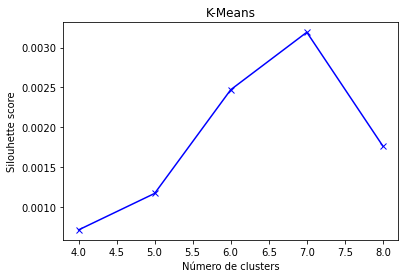

In [18]:
calcular_silhouette(X_train_tfidf,range(4,9,1))

#### Respuesta: Visualizando los valores obtenidos con silhouette score el mejor valor para el número de particiones es 7.

In [19]:
num_partition = 7
model_kmeans = KMeans(n_clusters=num_partition, init='k-means++', max_iter=300, random_state=10)
model_kmeans.fit(X_train_tfidf)
labels=model_kmeans.labels_

<Figure size 432x288 with 0 Axes>

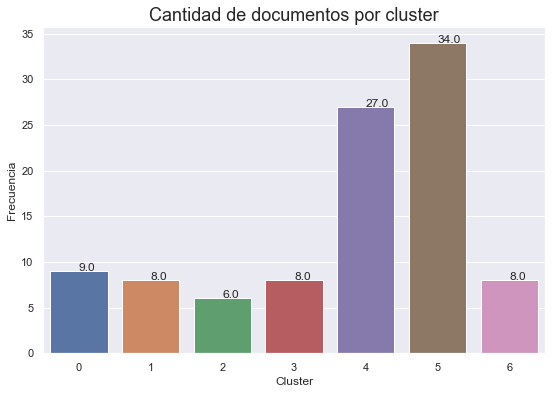

In [20]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

frequencies = dict(Counter(labels))

df_result = pd.DataFrame({"cluster": frequencies.keys(),"frequency": list(frequencies.values()) })
df_result.sort_values("cluster").reset_index(drop=True)
df_result["cluster"].astype(str)

plt.figure()

sns.set(font_scale=1)
plt.figure(figsize=(9, 6))

ax = sns.barplot(df_result.cluster, df_result.frequency, alpha=1)
plt.title('Cantidad de documentos por cluster', fontsize=18)
plt.ylabel('Frecuencia', fontsize=12)
plt.xlabel('Cluster', fontsize=12)

for p in ax.patches:
        ax.text(p.xy[0] + p.get_width()/2, p.xy[1] + p.get_height()+0.009, 
                str(round(p.get_height(), 3)), fontsize=12)
plt.show();

Muestre un WordCloud con los términos más representativos por cluster. ¿Existe alguna relación entre los clusters encontrados y el ranking de las películas?, e.g. el cluster $c_i$ está formado por películas con mas alto ranking que el cluster $c_j$

In [21]:
from collections import Counter
from tabulate import tabulate

In [22]:
REPLACE_BY_SPACE_RE = re.compile("[/(){}\[\]\|@,;(u'|')]")
generos = []
for g in genres:
    generos.append(REPLACE_BY_SPACE_RE.sub("", g).split())
                                 
movie_gen = dict(zip(titles, generos))

### Word Cloud

Cluster: 0
+-----------------------+----------------------------------------------------+
| title                 |                                             genero |
+-----------------------+----------------------------------------------------+
| Forrest Gump          |                               ['Drama', 'Romance'] |
| It's a Wonderful Life |                     ['Drama', 'Family', 'Fantasy'] |
| Apocalypse Now        |                                   ['Drama', 'War'] |
| Braveheart            | ['Action', 'Biography', 'Drama', 'History', 'War'] |
| City Lights           |                     ['Comedy', 'Drama', 'Romance'] |
| It Happened One Night |                              ['Comedy', 'Romance'] |
| A Place in the Sun    |                               ['Drama', 'Romance'] |
| The Graduate          |                     ['Comedy', 'Drama', 'Romance'] |
| Yankee Doodle Dandy   |                   ['Biography', 'Drama', 'Msical'] |
+-----------------------+----------------

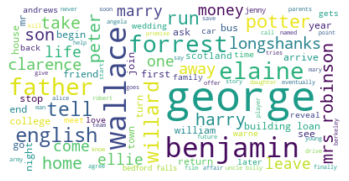

Cluster: 1
+------------------------------------+-----------------------------------+
| title                              |                            genero |
+------------------------------------+-----------------------------------+
| Sunset Blvd.                       |            ['Drama', 'Film-Noir'] |
| Singin' in the Rain                |   ['Comedy', 'Msical', 'Romance'] |
| Some Like It Hot                   |                        ['Comedy'] |
| Butch Cassidy and the Sundance Kid | ['Biography', 'Crime', 'Western'] |
| The Apartment                      |    ['Comedy', 'Drama', 'Romance'] |
| Midnight Cowboy                    |                         ['Drama'] |
| Network                            |                         ['Drama'] |
| Wuthering Heights                  |              ['Drama', 'Romance'] |
+------------------------------------+-----------------------------------+
Generos mas comunes: 	 [('Drama', 5), ('Comedy', 3), ('Romance', 3)]


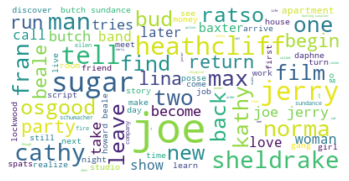

Cluster: 2
+----------------------------+---------------------------------------------+
| title                      |                                      genero |
+----------------------------+---------------------------------------------+
| The Godfather              |                          ['Crime', 'Drama'] |
| The Wizard of Oz           | ['Adventre', 'Family', 'Fantasy', 'Msical'] |
| The Godfather: Part II     |                          ['Crime', 'Drama'] |
| E.T. the Extra-Terrestrial |            ['Adventre', 'Family', 'Sci-Fi'] |
| My Fair Lady               |    ['Drama', 'Family', 'Msical', 'Romance'] |
| Tootsie                    |              ['Comedy', 'Drama', 'Romance'] |
+----------------------------+---------------------------------------------+
Generos mas comunes: 	 [('Drama', 4), ('Family', 3), ('Crime', 2)]


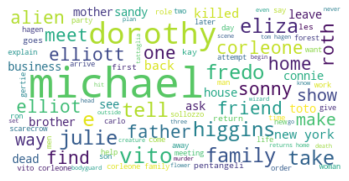

Cluster: 3
+------------------------------+--------------------------------------+
| title                        |                               genero |
+------------------------------+--------------------------------------+
| Citizen Kane                 |                 ['Drama', 'Mystery'] |
| The Silence of the Lambs     |       ['Crime', 'Drama', 'Thriller'] |
| Unforgiven                   |                          ['Western'] |
| Platoon                      |                     ['Drama', 'War'] |
| Mr. Smith Goes to Washington |                            ['Drama'] |
| Giant                        |                 ['Drama', 'Romance'] |
| Taxi Driver                  |                   ['Crime', 'Drama'] |
| The Third Man                | ['Film-Noir', 'Mystery', 'Thriller'] |
+------------------------------+--------------------------------------+
Generos mas comunes: 	 [('Drama', 6), ('Mystery', 2), ('Crime', 2)]


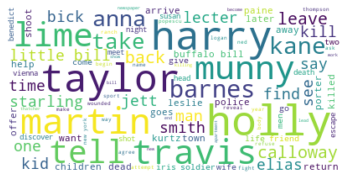

Cluster: 4
+----------------------------------------------------------------------+-------------------------------------------------------+
| title                                                                |                                                genero |
+----------------------------------------------------------------------+-------------------------------------------------------+
| Schindler's List                                                     |                     ['Biography', 'Drama', 'History'] |
| Casablanca                                                           |                           ['Drama', 'Romance', 'War'] |
| Lawrence of Arabia                                                   |  ['Adventre', 'Biography', 'Drama', 'History', 'War'] |
| The Sound of Music                                                   | ['Biography', 'Drama', 'Family', 'Msical', 'Romance'] |
| Star Wars                                                            |           ['A

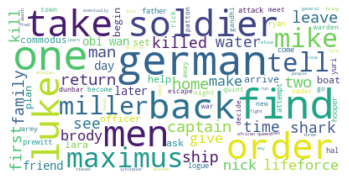

Cluster: 5
+-----------------------------------------------+-----------------------------------------------------+
| title                                         |                                              genero |
+-----------------------------------------------+-----------------------------------------------------+
| The Shawshank Redemption                      |                                  ['Crime', 'Drama'] |
| One Flew Over the Cuckoo's Nest               |                                           ['Drama'] |
| Gone with the Wind                            |                         ['Drama', 'Romance', 'War'] |
| Titanic                                       |                                ['Drama', 'Romance'] |
| Psycho                                        |                   ['Horror', 'Mystery', 'Thriller'] |
| Vertigo                                       |                  ['Mystery', 'Romance', 'Thriller'] |
| West Side Story                               | ['C

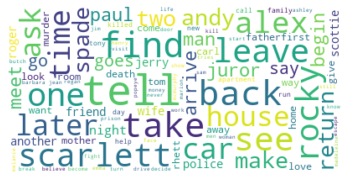

Cluster: 6
+------------------------------------+---------------------------------+
| title                              |                          genero |
+------------------------------------+---------------------------------+
| Raging Bull                        | ['Biography', 'Drama', 'Sport'] |
| On the Waterfront                  |              ['Crime', 'Drama'] |
| Amadeus                            |  ['Biography', 'Drama', 'Msic'] |
| An American in Paris               |           ['Msical', 'Romance'] |
| Rain Man                           |                       ['Drama'] |
| Shane                              | ['Drama', 'Romance', 'Western'] |
| Close Encounters of the Third Kind |             ['Drama', 'Sci-Fi'] |
| American Graffiti                  |             ['Comedy', 'Drama'] |
+------------------------------------+---------------------------------+
Generos mas comunes: 	 [('Drama', 7), ('Biography', 2), ('Romance', 2)]


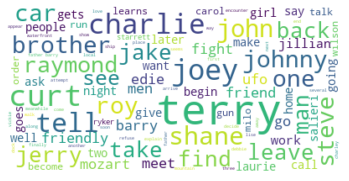

In [23]:
result={'cluster':labels,'movie':tokens_synopses}
movie_cl=pd.DataFrame(list(zip(titles,labels)),columns=['title','cluster'])
clusters = 7
result=pd.DataFrame(result)

for k in range(0,clusters):
    s=result[result.cluster==k]
    text=s['movie'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    
    print('Cluster: {}'.format(k))
    titles_=movie_cl[movie_cl.cluster==k]['title']
    
    tab = []
    gens = []
    for t in titles_:
        tab.append([t, movie_gen[t]])
        gens = gens + movie_gen[t]
        
    print(tabulate(tab, headers=['title', 'genero'], tablefmt='pretty', colalign=("left","right")))
    print("Generos mas comunes: \t", Counter(gens).most_common(3))
    
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

### Relación entre el Ranking y los clusters 

In [24]:
#Relationship between ranking and movies
titles_series = {'cluster':labels,'title':titles}
df_titles = pd.DataFrame(titles_series)
df_titles["ranking"] = [int(rank) for rank in range(1,101)] 
df_cluster_ranking = df_titles.sort_values("cluster")
df_cluster_ranking.reset_index(drop=True,inplace=True)
df_cluster_ranking = df_cluster_ranking[["cluster","ranking","title",]]
print("NOTA: El ranking es después de hacer el cluster para ver si existe una relación entre los clusters y el ranking")
df_cluster_ranking.head(23)

NOTA: El ranking es después de hacer el cluster para ver si existe una relación entre los clusters y el ranking


cluster  ranking                               title
0         0      100                 Yankee Doodle Dandy
1         0       27               It's a Wonderful Life
2         0       85                        The Graduate
3         0       17                        Forrest Gump
4         0       32                      Apocalypse Now
5         0       68                  A Place in the Sun
6         0       67               It Happened One Night
7         0       65                         City Lights
8         0       51                          Braveheart
9         1       28                    Some Like It Hot
10        1       14                        Sunset Blvd.
11        1       55                       The Apartment
12        1       26                 Singin' in the Rain
13        1       69                     Midnight Cowboy
14        1       83                             Network
15        1       94                   Wuthering Heights
16        1       53  Butch Cassidy and the Sundance Kid
17        2       46                        My Fair Lady
18        2       76                             Tootsie
19        2       21          E.T. the Extra-Terrestrial
20        2        1                       The Godfather
21        2        9                    The Wizard of Oz
22        2       12              The Godfather: Part II

#### ¿Existe alguna relación entre los clusters encontrados y el ranking de las películas?, e.g. el cluster  𝑐𝑖  está formado por películas con mas alto ranking que el cluster  𝑐𝑗

No existe una relación de los clusters con el ranking de las peliculas, en el cluster 0 se tiene peliculas de un ranking variado, en el cluster 1 y 2 tambien se presenta el mismo caso, como se visualiza en la tabla anterior.

### Analisis extra a los clusters

En base a las categorias mostradas anteriormente en el Word Cloud se puede observar que existe una agrupación de ciertas categorias en los clusters

- Cluster 0, agrupa peliculas de drama/romance
- Cluster 1, agrupa peliculas que son de drama/romance y comedia
- Cluster 2, agrupa peliculas de drama, familia y crimen este grupo podria ser de acción sin restricción de edad
- Cluster 3, agrupa peliculas de drama con misterio y crimen
- Cluster 4, agrupa peliculas de drama, biografia y guerra 
- Cluster 5, agrupa peliculas de Thriller en general
- Cluster 6, agrupa peliculas de drama, biografia y romance

Utilice un método como `t-sne`, `PCA`, o `ISOMAP` para realizar una transformación de datos a 2 dimensiones del dataset original. De esta manera, muestre en un espacio bi-dimensional los documentos del dataset, cada uno con un color que represente al cluster al que pertenece.

In [25]:
from sklearn.decomposition import PCA
import numpy as np

In [26]:
print("La dimensionalidad anterior es de %d registros y %d caracteristicas." % X_train_tfidf.shape)

pca = PCA(n_components=2,random_state=42)
pca_features_train_reduced = pca.fit_transform(X_train_tfidf.toarray())
print("La nueva dimensionaliad del dataset es de %d registros y %d caracteristicas." % pca_features_train_reduced.shape)


La dimensionalidad anterior es de 100 registros y 246706 caracteristicas.
La nueva dimensionaliad del dataset es de 100 registros y 2 caracteristicas.


#### Se toma el mismo número de clusters calculado anteriormete, siendo este valor de 7

In [27]:
num_cluster_pca = 7
model_kmeans = KMeans(n_clusters=num_cluster_pca, init='k-means++', max_iter=200, random_state=10)
model_kmeans.fit(pca_features_train_reduced)
labels=model_kmeans.labels_

In [28]:
df_reduced = pd.DataFrame(np.column_stack([pca_features_train_reduced,labels]), columns=["x", "y", "cluster_Kmeans"])
df_reduced

x         y  cluster_Kmeans
0   0.689031  0.089406             3.0
1  -0.040575 -0.029542             4.0
2  -0.027161 -0.062984             4.0
3  -0.041967  0.099044             1.0
4  -0.039179 -0.027255             4.0
..       ...       ...             ...
95 -0.011142 -0.002392             1.0
96  0.024562 -0.023731             4.0
97 -0.029473 -0.027661             4.0
98 -0.017690 -0.028053             4.0
99 -0.028333 -0.048760             4.0

[100 rows x 3 columns]

Text(0.5, 1.0, 'K-Means')

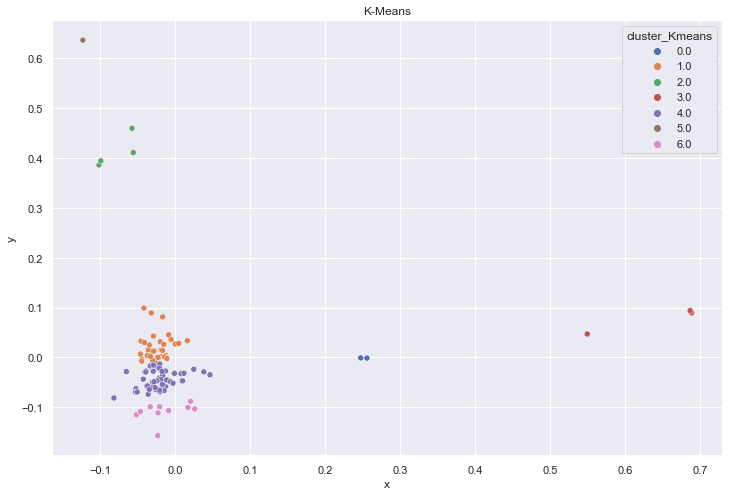

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.scatterplot(data=df_reduced, x="x", y="y", hue="cluster_Kmeans",legend="full",palette="deep")
ax.set_title('K-Means')

El siguiente código, calcula la matriz de similaridad de documentos basados en la distancia del coseno. El código a continuación asume que la variable que contiene la representación de la matriz TFIDF se llama `matriz_TFIDF`.

In [30]:
from sklearn.metrics.pairwise import cosine_similarity

#Se toma la matriz_TFIDF con unigramas, binogramas y trigramas
matriz_TFIDF = X_train_tfidf
similarity_distance = 1 - cosine_similarity(matriz_TFIDF)

Utilice esta matriz para realizar un nuevo clustering, esta vez usando `hierarchical clustering`. Muestre el dendograma resultante, seleccione la mejor partición de clusters en base a la métrica del `silhouette score`, y muestre el WordCloud de los clusters resultantes. ¿Los resultados son similares al ejercicio utilizando KMeans? elabore su respuesta.

In [31]:
from scipy.cluster.hierarchy import dendrogram,linkage
from sklearn.cluster import AgglomerativeClustering

In [32]:
def plot_dendrogram(model):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    dendrogram(linkage_matrix, truncate_mode='level', p=5)

In [33]:
def silhouette_hierarchical_clustering(x,range_analisis):
    res = []
    
    for c in range_analisis:
        aglomerative_clustering = AgglomerativeClustering(n_clusters=c)
        preds = aglomerative_clustering.fit_predict(x)
        
        silhouette_avg = silhouette_score(x, preds)
        res.append(silhouette_avg)  
    
    plt.plot(range_analisis, res,'bx-')
    plt.xlabel('Número de clusters')
    plt.ylabel('Silouhette score')
    plt.title('Aglomerative Clustering')
    plt.show()

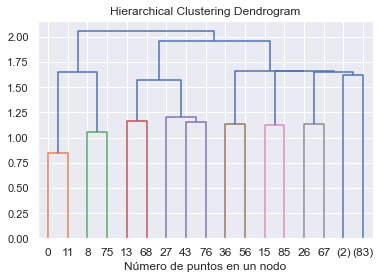

In [34]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(similarity_distance)
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model)
plt.xlabel("Número de puntos en un nodo")
plt.show()

#### El rango del silouhette score es tomado con 4<=k<=8 como se menciono anteriormente

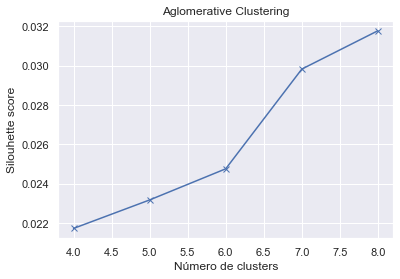

In [35]:
silhouette_hierarchical_clustering(similarity_distance,range(4,9,1))

#### El mejor valor para los clusters es de 8 tal como se lo muestra en la grafica.

In [36]:
n_clusters = 8
agl_clustering = AgglomerativeClustering(n_clusters=n_clusters)
preds = agl_clustering.fit_predict(similarity_distance)

### Word Cloud

Cluster: 0
Titles:
                          The Shawshank Redemption
                                  Schindler's List
                                       Raging Bull
                                        Casablanca
                   One Flew Over the Cuckoo's Nest
                                Gone with the Wind
                                      Citizen Kane
                                           Titanic
                                Lawrence of Arabia
                                            Psycho
                                           Vertigo
                                      Forrest Gump
                                The Sound of Music
                                   West Side Story
                                         Star Wars
                        E.T. the Extra-Terrestrial
                             2001: A Space Odyssey
                          The Silence of the Lambs
                                         Chinatown
            

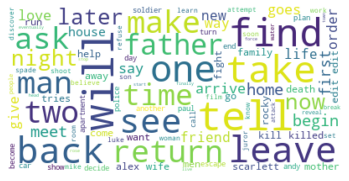

Cluster: 1
Titles:
 Butch Cassidy and the Sundance Kid
                       Pulp Fiction


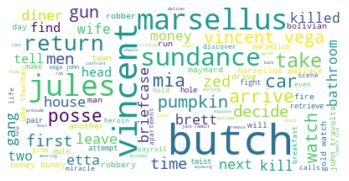

Cluster: 2
Titles:
         Sunset Blvd.
     Some Like It Hot
 An American in Paris
      Midnight Cowboy
                Fargo


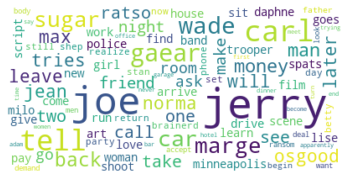

Cluster: 3
Titles:
 Saving Private Ryan
           High Noon


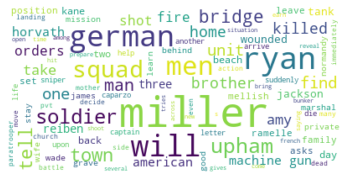

Cluster: 4
Titles:
 On the Waterfront
 American Graffiti


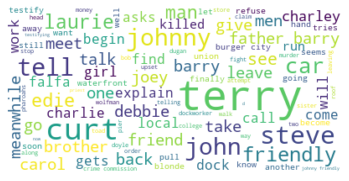

Cluster: 5
Titles:
 It's a Wonderful Life
    A Place in the Sun


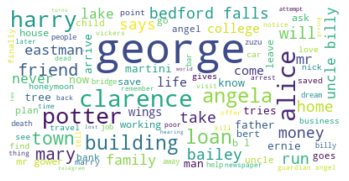

Cluster: 6
Titles:
          The Godfather
 The Godfather: Part II


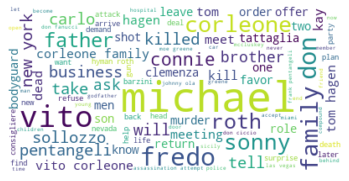

Cluster: 7
Titles:
 The Wizard of Oz
          Tootsie


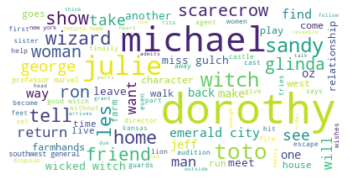

In [37]:
titles_series_aggl = {'cluster':preds,'title':titles}
df_titles_aggl = pd.DataFrame(titles_series_aggl)

result_aggl={'cluster':preds,'synopses':synopses}
result_aggl=pd.DataFrame(result_aggl)

for k in range(0,n_clusters):
    s=result_aggl[result_aggl.cluster==k]
    text=s['synopses'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    
    print('Cluster: {}'.format(k))
    print('Titles:')
    
    titles_result=df_titles_aggl[df_titles_aggl.cluster==k]['title']
    
    print(titles_result.to_string(index=False))
    
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

### Grafico adicional de la matriz de similaridad empleando PCA

Se realiza la graficación en un espacio bi-dimensional la matriz de similaridad de documentos basados en la distancia del coseno, con cada uno de los colores que represente al cluster al que pertenece, para tener un mejor criterio.

In [38]:
pca = PCA(n_components=2,random_state=42)
pca_features_train_similarity = pca.fit_transform(similarity_distance)

In [39]:
n_clusters = 8
agl_clustering = AgglomerativeClustering(n_clusters=n_clusters)
preds = agl_clustering.fit_predict(pca_features_train_similarity)

In [40]:
df_reduced_aggl = pd.DataFrame(np.column_stack([pca_features_train_similarity,preds]), columns=["x", "y", "aglomerative_clustering"])
df_reduced_aggl.head(5)

x         y  aglomerative_clustering
0  0.856798  0.089330                      6.0
1 -0.042869 -0.049285                      0.0
2 -0.035240 -0.070132                      0.0
3 -0.029655  0.066916                      1.0
4 -0.050449 -0.026323                      0.0

Text(0.5, 1.0, 'Aglomerative Clustering')

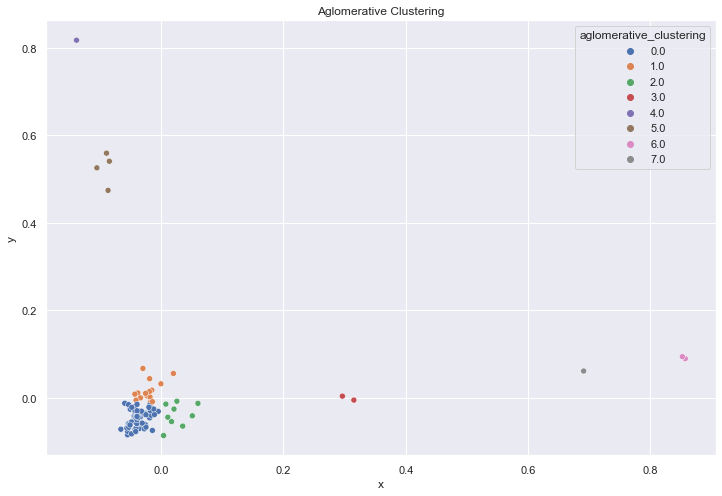

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.scatterplot(data=df_reduced_aggl, x="x", y="y", hue="aglomerative_clustering",legend="full",palette="deep")
ax.set_title('Aglomerative Clustering')

#### ¿Los resultados son similares al ejercicio utilizando KMeans? elabore su respuesta.

El número de clusters obtenidos con K-means es de 7 y con agglomerative clustering se tienen 8, por lo que hay una diferencia de un cluster. Los resultado obtenidos con los dos algoritmos varian, pero en la representación grafica en dos dimensiones presentan resultados similares, esto es debido a que los dos realizan una clusterización en los mismos sectores del plano cartesiano.

## Ejercicio 3

Siguiendo un proceso similar al ejercicio anterior, pero esta vez utilizando las técnicas de `OPTICS` y `DBSCAN`, encuentre automáticamente las particiones de este dataset. Los métodos antes mencionados son bastante sensibles a sus hyper-parámetros; por lo tanto, modifíquelos para obtener resultados relevantes.

In [151]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.cluster import OPTICS

In [18]:
# filtrado de caracteres y stopwords
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
stopwords_ = stopwords.words('english')
stopwords_.extend(['plot', 'edit']) # Adding new stopwords to the set, 'cause theese words repeat in all docs
STOPWORDS = set(stopwords_)

sypnopses_clean = []
for text in synopses:
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    
    sypnopses_clean.append(text)

In [205]:
# Parameter tunning
num_samples = range(2,11)
eps = np.arange(0,1,0.1).tolist()

In [206]:
tab = []
for sample in num_samples:
    for ep in eps:
        clustering_o = OPTICS(min_samples=sample, eps=ep).fit(similarity_distance)
        labels_o = clustering_o.labels_
        try:
            score = silhouette_score(similarity_distance, labels_o)
        
            tab.append([str(sample), format(ep, '.4f'), 
                format(score, '.8f')])
        except:
            pass

print(tabulate(sorted(tab, key=lambda item:item[2], reverse=True)[:5], 
               headers=['min_samples', 'eps', 'silhoutte'], tablefmt='pretty'))

+-------------+--------+------------+
| min_samples |  eps   | silhoutte  |
+-------------+--------+------------+
|      2      | 0.0000 | 0.03436132 |
|      2      | 0.1000 | 0.03436132 |
|      2      | 0.2000 | 0.03436132 |
|      2      | 0.3000 | 0.03436132 |
|      2      | 0.4000 | 0.03436132 |
+-------------+--------+------------+


#### _Los mejores parametros son `min_samples=2`, `eps=0.4`_

In [219]:
model_optics =  OPTICS(min_samples=2, eps=0.4)
model_optics.fit(similarity_distance)
labels= model_optics.labels_
optics_cl=pd.DataFrame(list(zip(titles,labels)),columns=['title','cluster'])
print(optics_cl.sort_values(by=['cluster']))

                                 title  cluster
99                 Yankee Doodle Dandy       -1
51      The Good, the Bad and the Ugly       -1
50                          Braveheart       -1
98                  North by Northwest       -1
48                              Patton       -1
..                                 ...      ...
86                        Pulp Fiction        9
52  Butch Cassidy and the Sundance Kid        9
18                     West Side Story       10
17                  The Sound of Music       10
49                                Jaws       10

[100 rows x 2 columns]


In [208]:
import matplotlib.pyplot as plt
import seaborn as sns

In [209]:
dist_optics = optics_cl.groupby(['cluster']).size()

<Figure size 432x288 with 0 Axes>

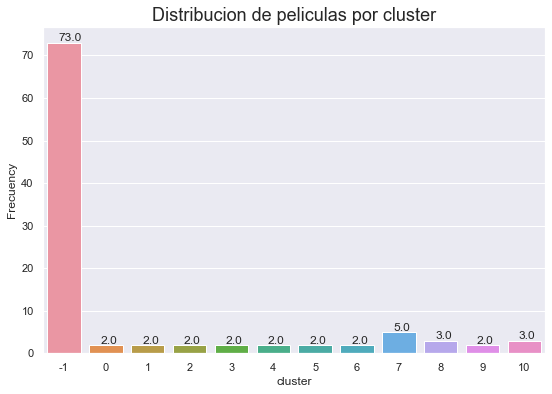

In [210]:
plt.figure()

sns.set(font_scale=1)
plt.figure(figsize=(9, 6))

ax = sns.barplot(dist_optics.index, dist_optics.values, alpha=1)
plt.title('Distribucion de peliculas por cluster', fontsize=18)
plt.ylabel('Frecuency', fontsize=12)

for p in ax.patches:
        ax.text(p.xy[0] + p.get_width()/3, p.xy[1] + p.get_height()+0.3, 
                str(round(p.get_height(), 3)), fontsize=12)
plt.show()

Cluster: -1
+----------------------------------------------------------------------+------------------------------------------------------+
| title                                                                |                                               genero |
+----------------------------------------------------------------------+------------------------------------------------------+
| The Shawshank Redemption                                             |                                   ['Crime', 'Drama'] |
| Casablanca                                                           |                          ['Drama', 'Romance', 'War'] |
| One Flew Over the Cuckoo's Nest                                      |                                            ['Drama'] |
| Gone with the Wind                                                   |                          ['Drama', 'Romance', 'War'] |
| Citizen Kane                                                         |                    

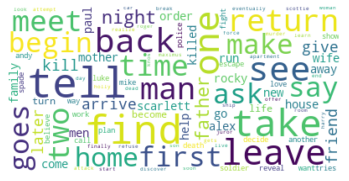

Cluster: 0
+------------------------+--------------------+
| title                  |             genero |
+------------------------+--------------------+
| The Godfather          | ['Crime', 'Drama'] |
| The Godfather: Part II | ['Crime', 'Drama'] |
+------------------------+--------------------+
Generos mas comunes: 	 [('Crime', 2), ('Drama', 2)]


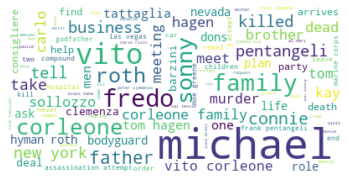

Cluster: 1
+------------------+---------------------------------------------+
| title            |                                      genero |
+------------------+---------------------------------------------+
| The Wizard of Oz | ['Adventre', 'Family', 'Fantasy', 'Msical'] |
| Tootsie          |              ['Comedy', 'Drama', 'Romance'] |
+------------------+---------------------------------------------+
Generos mas comunes: 	 [('Adventre', 1), ('Family', 1), ('Fantasy', 1)]


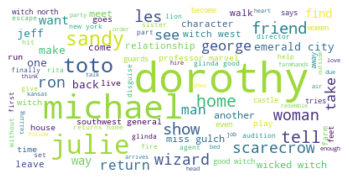

Cluster: 2
+-------------------+---------------------+
| title             |              genero |
+-------------------+---------------------+
| On the Waterfront |  ['Crime', 'Drama'] |
| American Graffiti | ['Comedy', 'Drama'] |
+-------------------+---------------------+
Generos mas comunes: 	 [('Drama', 2), ('Crime', 1), ('Comedy', 1)]


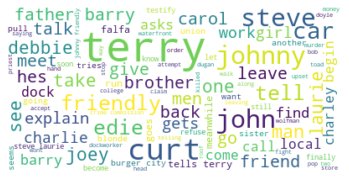

Cluster: 3
+-------------+----------------------------------+
| title       |                           genero |
+-------------+----------------------------------+
| Raging Bull |  ['Biography', 'Drama', 'Sport'] |
| Chinatown   | ['Drama', 'Mystery', 'Thriller'] |
+-------------+----------------------------------+
Generos mas comunes: 	 [('Drama', 2), ('Biography', 1), ('Sport', 1)]


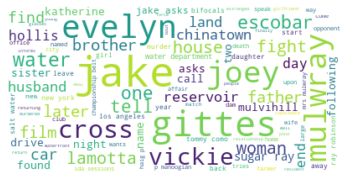

Cluster: 4
+-----------------------+--------------------------------+
| title                 |                         genero |
+-----------------------+--------------------------------+
| It's a Wonderful Life | ['Drama', 'Family', 'Fantasy'] |
| A Place in the Sun    |           ['Drama', 'Romance'] |
+-----------------------+--------------------------------+
Generos mas comunes: 	 [('Drama', 2), ('Family', 1), ('Fantasy', 1)]


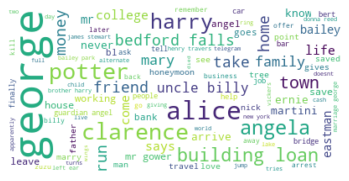

Cluster: 5
+---------------------+----------------------------+
| title               |                     genero |
+---------------------+----------------------------+
| Saving Private Ryan | ['Action', 'Drama', 'War'] |
| High Noon           |                ['Western'] |
+---------------------+----------------------------+
Generos mas comunes: 	 [('Action', 1), ('Drama', 1), ('War', 1)]


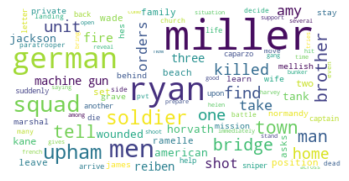

Cluster: 6
+------------------+-----------------------------------+
| title            |                            genero |
+------------------+-----------------------------------+
| Schindler's List | ['Biography', 'Drama', 'History'] |
| The Pianist      |     ['Biography', 'Drama', 'War'] |
+------------------+-----------------------------------+
Generos mas comunes: 	 [('Biography', 2), ('Drama', 2), ('History', 1)]


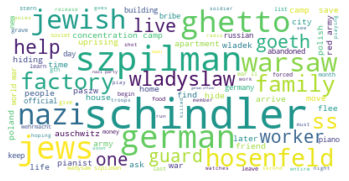

Cluster: 7
+----------------------+--------------------------------+
| title                |                         genero |
+----------------------+--------------------------------+
| Sunset Blvd.         |         ['Drama', 'Film-Noir'] |
| Some Like It Hot     |                     ['Comedy'] |
| An American in Paris |          ['Msical', 'Romance'] |
| Midnight Cowboy      |                      ['Drama'] |
| Fargo                | ['Crime', 'Drama', 'Thriller'] |
+----------------------+--------------------------------+
Generos mas comunes: 	 [('Drama', 3), ('Film-Noir', 1), ('Comedy', 1)]


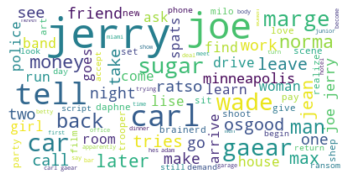

Cluster: 8
+-------------------+--------------------------------+
| title             |                         genero |
+-------------------+--------------------------------+
| Titanic           |           ['Drama', 'Romance'] |
| Rain Man          |                      ['Drama'] |
| The African Queen | ['Adventre', 'Romance', 'War'] |
+-------------------+--------------------------------+
Generos mas comunes: 	 [('Drama', 2), ('Romance', 2), ('Adventre', 1)]


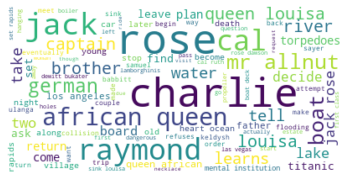

Cluster: 9
+------------------------------------+-----------------------------------+
| title                              |                            genero |
+------------------------------------+-----------------------------------+
| Butch Cassidy and the Sundance Kid | ['Biography', 'Crime', 'Western'] |
| Pulp Fiction                       |    ['Crime', 'Drama', 'Thriller'] |
+------------------------------------+-----------------------------------+
Generos mas comunes: 	 [('Crime', 2), ('Biography', 1), ('Western', 1)]


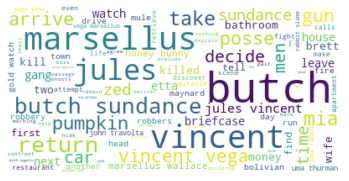

Cluster: 10
+--------------------+-------------------------------------------------------+
| title              |                                                genero |
+--------------------+-------------------------------------------------------+
| The Sound of Music | ['Biography', 'Drama', 'Family', 'Msical', 'Romance'] |
| West Side Story    |   ['Crime', 'Drama', 'Msical', 'Romance', 'Thriller'] |
| Jaws               |                                 ['Drama', 'Thriller'] |
+--------------------+-------------------------------------------------------+
Generos mas comunes: 	 [('Drama', 3), ('Msical', 2), ('Romance', 2)]


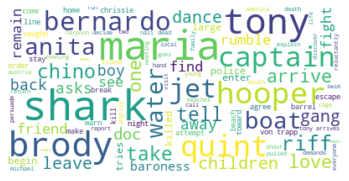

In [212]:
result={'cluster':labels,'movie':sypnopses_clean}
result=pd.DataFrame(result)


for k in range(-1,11):
    s=result[result.cluster==k]
    text=s['movie'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    
    print('Cluster: {}'.format(k))
    #print('Titles ---------------------')
    
    titles_=optics_cl[optics_cl.cluster==k]['title']
    
    tab = []
    gens = []
    for t in titles_:
        tab.append([t, movie_gen[t]])
        gens = gens + movie_gen[t]
        
    print(tabulate(tab, headers=['title', 'genero'], tablefmt='pretty', colalign=("left","right")))
    print("Generos mas comunes: \t", Counter(gens).most_common(3))
    
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

#### _Se puede observar que el algoritmo OPTICS marca como outliers a las peliculas que tengan que ver con Drama/Romance/Guerra, a diferencia de los otros clusters, que contienen pocas peliculas, pero muy parecidas entre si_

In [220]:
optics_reduced = PCA(n_components=2, random_state=42)
optics_matrix = pca_reduced.fit_transform(tfidf_matrix.toarray())
print("La nueva dimensionaliad del dataset es de %d registros y %d caracteristicas." % optics_matrix.shape)

La nueva dimensionaliad del dataset es de 100 registros y 2 caracteristicas.


In [223]:
optics_cl=pd.DataFrame(list(zip(titles,labels)),columns=['title','cluster'])
df_reduced = pd.DataFrame(np.column_stack([optics_matrix, labels]), columns=["x", "y", "cluster"])

Text(0.5, 1.0, 'OPTICS')

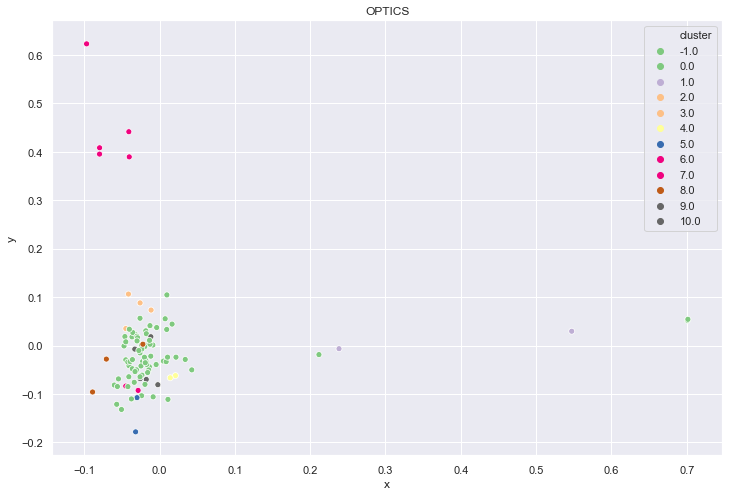

In [225]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.scatterplot(data=df_reduced, x="x", y="y", hue="cluster",legend="full", palette="Accent")
ax.set_title('OPTICS')

#### _En el scatterplot se puede observar que los datos que no pertencen a ningun cluster se encuentran aglomerados entre si. Cuando deberian marcar como atipicos a los que se encuentran mas al exterior._

## DBSCAN

In [226]:
from sklearn.cluster import DBSCAN

In [233]:
# Parameter tunning
num_samples = range(2,11)
eps = np.arange(0.1,1,0.01).tolist()

In [234]:
tab = []
for sample in num_samples:
    for ep in eps:
        clustering_d = DBSCAN(min_samples=sample, eps=ep).fit(similarity_distance)
        labels_d = clustering_d.labels_
        try:
            score = silhouette_score(similarity_distance, labels_d)
        
            tab.append([str(sample), format(ep, '.4f'), 
                format(score, '.8f')])
        except:
            pass

print(tabulate(sorted(tab, key=lambda item:item[2], reverse=True)[:5], 
               headers=['min_samples', 'eps', 'silhoutte'], tablefmt='pretty'))

+-------------+--------+------------+
| min_samples |  eps   | silhoutte  |
+-------------+--------+------------+
|      2      | 0.8300 | 0.04441336 |
|      2      | 0.8400 | 0.04441336 |
|      2      | 0.8500 | 0.04441336 |
|      2      | 0.8600 | 0.04441336 |
|      2      | 0.8700 | 0.04441336 |
+-------------+--------+------------+


#### _Los mejores parametros son `min_samples=2`, `eps=0.85`_

In [241]:
model_dbscan =  DBSCAN(min_samples=2, eps=0.85)
model_dbscan.fit(similarity_distance)
labels= model_dbscan.labels_
dbscan_cl=pd.DataFrame(list(zip(titles,labels)),columns=['title','cluster'])
print(dbscan_cl.sort_values(by=['cluster']))

                           title  cluster
49                          Jaws       -1
72                 Out of Africa       -1
71                    Annie Hall       -1
70                      Rain Man       -1
69  Mr. Smith Goes to Washington       -1
..                           ...      ...
27              Some Like It Hot       -1
36           Saving Private Ryan       -1
47                Doctor Zhivago       -1
11        The Godfather: Part II        0
0                  The Godfather        0

[100 rows x 2 columns]


In [242]:
import matplotlib.pyplot as plt
import seaborn as sns

In [244]:
dist_dbscan = dbscan_cl.groupby(['cluster']).size()

<Figure size 432x288 with 0 Axes>

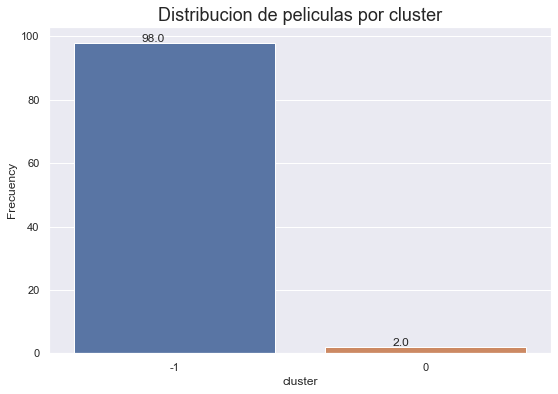

In [245]:
plt.figure()

sns.set(font_scale=1)
plt.figure(figsize=(9, 6))

ax = sns.barplot(dist_dbscan.index, dist_dbscan.values, alpha=1)
plt.title('Distribucion de peliculas por cluster', fontsize=18)
plt.ylabel('Frecuency', fontsize=12)

for p in ax.patches:
        ax.text(p.xy[0] + p.get_width()/3, p.xy[1] + p.get_height()+0.3, 
                str(round(p.get_height(), 3)), fontsize=12)
plt.show()

Cluster: -1
+----------------------------------------------------------------------+-------------------------------------------------------+
| title                                                                |                                                genero |
+----------------------------------------------------------------------+-------------------------------------------------------+
| The Shawshank Redemption                                             |                                    ['Crime', 'Drama'] |
| Schindler's List                                                     |                     ['Biography', 'Drama', 'History'] |
| Raging Bull                                                          |                       ['Biography', 'Drama', 'Sport'] |
| Casablanca                                                           |                           ['Drama', 'Romance', 'War'] |
| One Flew Over the Cuckoo's Nest                                      |             

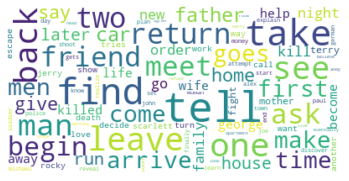

Cluster: 0
+------------------------+--------------------+
| title                  |             genero |
+------------------------+--------------------+
| The Godfather          | ['Crime', 'Drama'] |
| The Godfather: Part II | ['Crime', 'Drama'] |
+------------------------+--------------------+
Generos mas comunes: 	 [('Crime', 2), ('Drama', 2)]


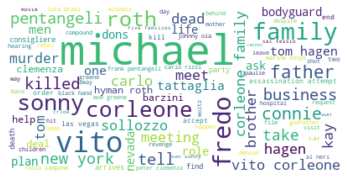

In [247]:
result={'cluster':labels,'movie':sypnopses_clean}
result=pd.DataFrame(result)


for k in range(-1,1):
    s=result[result.cluster==k]
    text=s['movie'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    
    print('Cluster: {}'.format(k))
    #print('Titles ---------------------')
    
    titles_=dbscan_cl[dbscan_cl.cluster==k]['title']
    
    tab = []
    gens = []
    for t in titles_:
        tab.append([t, movie_gen[t]])
        gens = gens + movie_gen[t]
        
    print(tabulate(tab, headers=['title', 'genero'], tablefmt='pretty', colalign=("left","right")))
    print("Generos mas comunes: \t", Counter(gens).most_common(3))
    
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

#### _Se puede observar que el algoritmo DBSCAN separa los datos en dos cluster desbalanceados, al parecer solo toma como un cluster a las peliculas que tienen continuacion, en este caso The Godfather 1 y 2._

In [249]:
dbscan_reduced = PCA(n_components=2, random_state=42)
dbscan_matrix = dbscan_reduced.fit_transform(tfidf_matrix.toarray())
print("La nueva dimensionaliad del dataset es de %d registros y %d caracteristicas." % dbscan_matrix.shape)

La nueva dimensionaliad del dataset es de 100 registros y 2 caracteristicas.


In [250]:
dbscan_cl=pd.DataFrame(list(zip(titles,labels)),columns=['title','cluster'])
df_reduced = pd.DataFrame(np.column_stack([dbscan_matrix, labels]), columns=["x", "y", "cluster"])

Text(0.5, 1.0, 'DBSCAN')

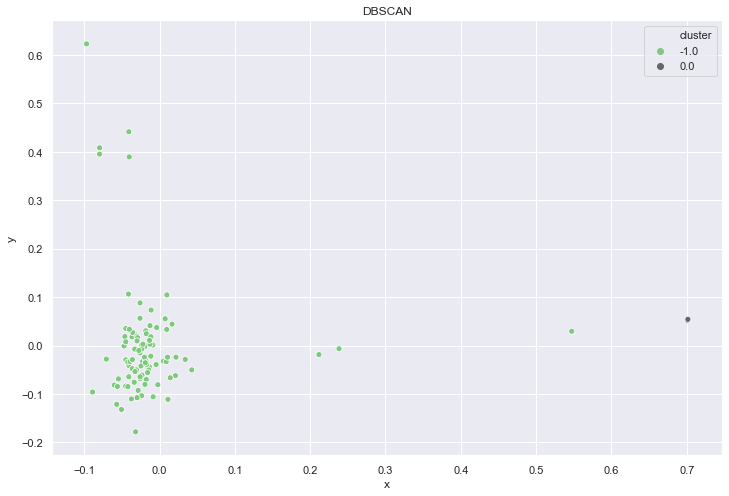

In [252]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.scatterplot(data=df_reduced, x="x", y="y", hue="cluster",legend="full", palette="Accent")
ax.set_title('DBSCAN')

#### _En esta ultima grafica se observa a las peliculas de The Godfather una sobre otra, mientras que el resto es marcado como un grupo desconocido_

Según el funcionamiento de DBSCAN "agrupa puntos que están muy juntos (puntos con muchos vecinos cercanos), marcando como valores atípicos puntos que se encuentran solos en regiones de baja densidad (cuyos vecinos más cercanos están demasiado lejos)". Me parece algo raro que pase esto. 